In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn
import mlflow.xgboost


In [2]:
#data = pd.read_excel(r'C:\Users\mbauer2\workspace\Uni\enterprise-ai-project\ImmmoWelt_Price_Guide\houses_to_buy_nbg_preprocessed.xlsx')
data = pd.read_excel(r'C:\Users\mbauer2\workspace\Uni\enterprise-ai-project\ImmmoWelt_Price_Guide\data\flats_to_rent_wue_preprocessed_0407.xlsx')

In [3]:
data.replace('""', np.nan, inplace=True)

In [4]:
data['DistributionType'].unique()

array(['RENT'], dtype=object)

In [148]:
data = data[data['DistributionType']=='BUY']

In [149]:
data = data[data['EstateType']=='HOUSE']

In [5]:
data

,Unnamed: 0,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abstellraum,als_ferienimmobilie_geeignet,...,teppich,terrasse,tiefgarage,vermietet,wanne,wasch_trockenraum,wg_geeignet,wintergarten,wohnberechtigungsschein,zentralheizung
0,0,995.0,50.0,1.5,2012.0,97084,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,475.0,50.0,2.0,NaN,97209,APARTMENT,RENT,0,0,...,0,0,0,0,1,1,0,0,0,0
2,2,750.0,70.0,2.0,1956.0,97297,APARTMENT,RENT,0,0,...,0,0,0,0,1,0,1,0,0,1
3,3,580.0,74.0,3.0,1940.0,97249,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,780.0,86.0,3.0,1995.0,97297,APARTMENT,RENT,0,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,560.0,50.0,2.0,NaN,97076,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,0,0,0,1
172,172,750.0,72.0,2.0,1970.0,97084,APARTMENT,RENT,0,0,...,0,0,0,0,0,0,0,0,0,0
173,173,2175.0,150.0,5.5,NaN,97070,APARTMENT,RENT,1,0,...,0,0,0,0,1,0,0,0,0,1
174,174,1185.0,85.0,3.0,1920.0,97078,APARTMENT,RENT,0,0,...,0,0,0,0,1,0,0,0,0,1


In [6]:
data['ConstructionYear'].isnull().sum()
print(data.isnull().sum())

Unnamed: 0                  0
Object_price                0
LivingSpace                 0
Rooms                       0
ConstructionYear           38
                           ..
wasch_trockenraum           0
wg_geeignet                 0
wintergarten                0
wohnberechtigungsschein     0
zentralheizung              0
Length: 87, dtype: int64


In [7]:
data.dropna(inplace=True)
data["LivingSpace"] = pd.to_numeric(data["LivingSpace"], errors="coerce")
data["Rooms"] = pd.to_numeric(data["Rooms"], errors="coerce")
data.dropna(subset=['ConstructionYear'], inplace=True)
data.dropna(subset=['Object_price'], inplace=True)
data.dropna(subset=['Rooms'], inplace=True)
data.dropna(subset=['LivingSpace'], inplace=True)
#data.drop('ContactData', axis=1, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
#data.drop('Object_currency', axis=1, inplace=True)
#data.drop('Url', axis=1, inplace=True)
#data.drop('EstateType', axis=1, inplace=True)
#data.drop('DistributionType', axis=1, inplace=True)
data['ZipCode']= data['ZipCode'].astype(str)
data['LivingSpace']= data['LivingSpace'].astype(float)
data = data.reindex()

In [8]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abstellraum,als_ferienimmobilie_geeignet,altbau_(bis_1945),...,teppich,terrasse,tiefgarage,vermietet,wanne,wasch_trockenraum,wg_geeignet,wintergarten,wohnberechtigungsschein,zentralheizung
0,995.0,50.0,1.5,2012.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,750.0,70.0,2.0,1956.0,97297,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,580.0,74.0,3.0,1940.0,97249,APARTMENT,RENT,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,780.0,86.0,3.0,1995.0,97297,APARTMENT,RENT,0,0,0,...,1,0,0,0,1,0,0,0,0,1
6,1250.0,115.0,3.5,2019.0,97246,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,2880.0,195.0,6.0,2023.0,97218,APARTMENT,RENT,0,0,0,...,0,1,0,0,1,0,0,0,0,0
169,1100.0,103.0,4.0,1984.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,0
170,715.0,82.2,3.0,1900.0,97299,APARTMENT,RENT,0,0,1,...,0,0,0,0,1,0,0,0,0,0
172,750.0,72.0,2.0,1970.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(data.isnull().sum())

Object_price               0
LivingSpace                0
Rooms                      0
ConstructionYear           0
ZipCode                    0
                          ..
wasch_trockenraum          0
wg_geeignet                0
wintergarten               0
wohnberechtigungsschein    0
zentralheizung             0
Length: 86, dtype: int64


In [10]:
data = data.reset_index(drop=True)

In [11]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abstellraum,als_ferienimmobilie_geeignet,altbau_(bis_1945),...,teppich,terrasse,tiefgarage,vermietet,wanne,wasch_trockenraum,wg_geeignet,wintergarten,wohnberechtigungsschein,zentralheizung
0,995.0,50.0,1.5,2012.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,750.0,70.0,2.0,1956.0,97297,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,580.0,74.0,3.0,1940.0,97249,APARTMENT,RENT,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,780.0,86.0,3.0,1995.0,97297,APARTMENT,RENT,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,1250.0,115.0,3.5,2019.0,97246,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2880.0,195.0,6.0,2023.0,97218,APARTMENT,RENT,0,0,0,...,0,1,0,0,1,0,0,0,0,0
134,1100.0,103.0,4.0,1984.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,1,0,1,0,0,0
135,715.0,82.2,3.0,1900.0,97299,APARTMENT,RENT,0,0,1,...,0,0,0,0,1,0,0,0,0,0
136,750.0,72.0,2.0,1970.0,97084,APARTMENT,RENT,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\mbauer2\AppData\Local\Temp\ipykernel_19660\1150594620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="RdBu")


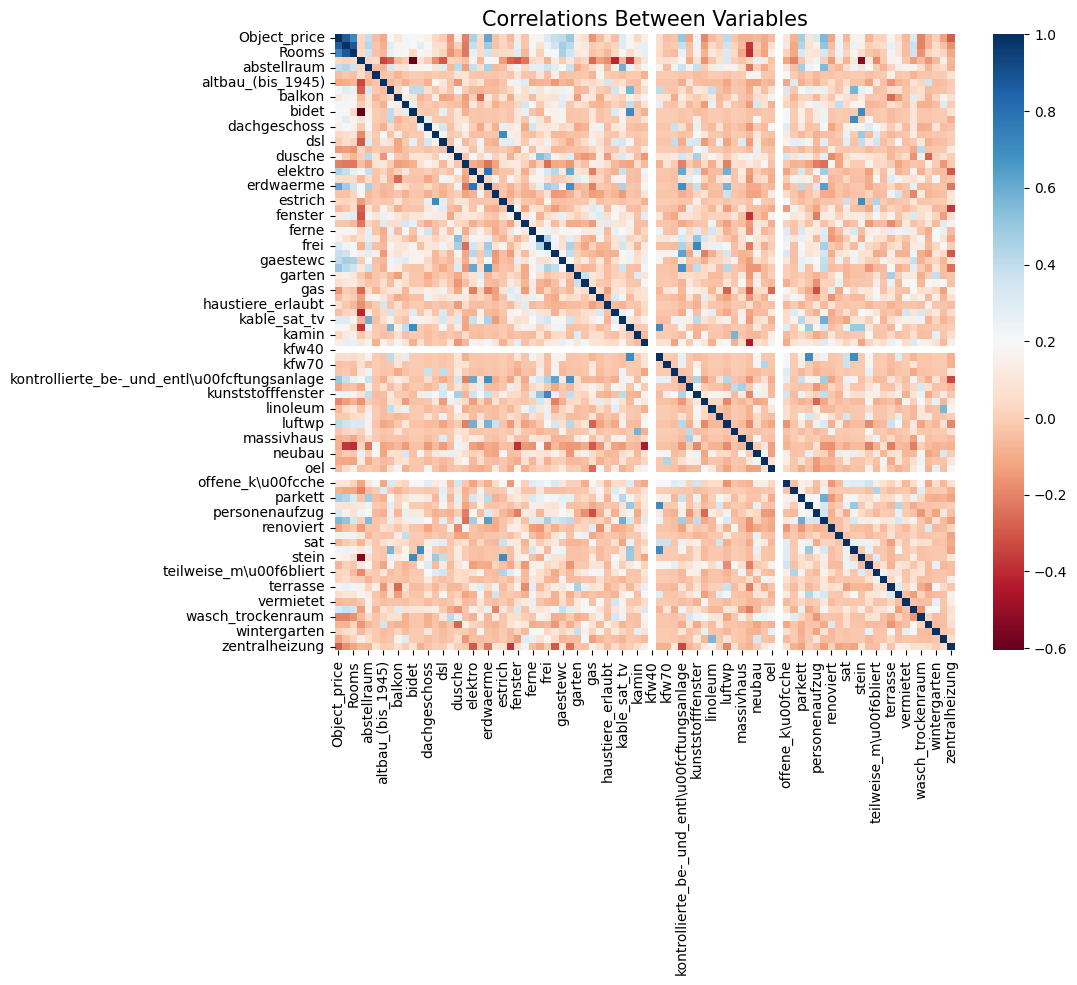

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [13]:
important_num_cols = list(data.corr()["Object_price"][(data.corr()["Object_price"]>0.20) | (data.corr()["Object_price"]<-0.20)].index)

C:\Users\mbauer2\AppData\Local\Temp\ipykernel_19660\847568539.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  important_num_cols = list(data.corr()["Object_price"][(data.corr()["Object_price"]>0.20) | (data.corr()["Object_price"]<-0.20)].index)


In [14]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
cat_cols

['ZipCode', 'EstateType', 'DistributionType']

In [15]:
important_cols = important_num_cols + cat_cols

data = data[important_cols]

In [16]:
important_num_cols

['Object_price',
 'LivingSpace',
 'Rooms',
 'abstellraum',
 'bad/wc_getrennt',
 'barriefrei',
 'bidet',
 'einbauk\\u00fcche',
 'elektro',
 'erdwaerme',
 'frei',
 'fu\\u00dfbodenheizung',
 'gaestewc',
 'garage',
 'kable_sat_tv',
 'kontrollierte_be-_und_entl\\u00fcftungsanlage',
 'kunststofffenster',
 'luftwp',
 'parkett',
 'personenaufzug',
 'reinigung',
 'rollstuhlgerecht',
 'wanne',
 'wasch_trockenraum',
 'zentralheizung']

In [17]:
y = data['Object_price']
X = data.drop('Object_price', axis=1)
print(y.head())
print(X.head())

0     995.0
1     750.0
2     580.0
3     780.0
4    1250.0
Name: Object_price, dtype: float64
   LivingSpace  Rooms  abstellraum  bad/wc_getrennt  barriefrei  bidet  \
0         50.0    1.5            0                0           0      0   
1         70.0    2.0            0                0           0      0   
2         74.0    3.0            0                0           0      0   
3         86.0    3.0            0                0           0      0   
4        115.0    3.5            0                0           1      0   

   einbauk\u00fcche  elektro  erdwaerme  frei  ...  parkett  personenaufzug  \
0                 1        0          0     0  ...        0               0   
1                 1        0          0     0  ...        0               0   
2                 1        1          0     0  ...        0               0   
3                 1        0          0     0  ...        0               0   
4                 0        0          0     0  ...        0      

In [18]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

In [19]:
num_cols = [col for col in train_X.columns if train_X[col].dtype == 'float64']
cat_cols = [col for col in train_X.columns if train_X[col].dtype == 'object']
bin_cols = [col for col in train_X.columns if train_X[col].dtype == 'int64']

In [21]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)

In [22]:
X_train_processed[0]

array([  1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   1. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   1. ,   0. ,   0. , 104. ,   3.5,   0. ,   0. ,   1. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         1. ,   1. ])

In [26]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.xgboost.autolog(disable=True)
mlflow.start_run(run_name='michel_xgb')

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)

k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True)
fold_scores = []
model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=30)
for train_index, val_index in kf.split(X_train_processed):
    fold_train_X, fold_val_X = X_train_processed[train_index], X_train_processed[val_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[val_index]
    model.fit(X=fold_train_X, y=fold_train_y, eval_set=[(fold_val_X, fold_val_y)], verbose=True)
    fold_preds = model.predict(fold_val_X)
    fold_score = mean_absolute_error(fold_val_y, fold_preds)
    fold_scores.append(fold_score)

# Durchschnittliche Bewertung über alle Folds
average_score = np.mean(fold_scores)
print("Durchschnittlicher MAE über 10 Folds:", average_score)

# Modellvorhersage für Testdaten
test_preds = model.predict(X_test_processed)

# Bewertung auf Testdaten
test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)
mlflow.sklearn.log_model(model, "ridge-regression-model")
mlflow.log_metric("mse",  mean_squared_error(val_y, test_preds) )
mlflow.log_metric("mae",mean_absolute_error(val_y, test_preds))


mlflow.end_run()

[0]	validation_0-rmse:844.12118	validation_0-mae:771.89104
[1]	validation_0-rmse:607.16989	validation_0-mae:546.85400
[2]	validation_0-rmse:422.87705	validation_0-mae:371.51084
[3]	validation_0-rmse:293.37400	validation_0-mae:232.26741
[4]	validation_0-rmse:231.16159	validation_0-mae:144.16986
[5]	validation_0-rmse:187.73518	validation_0-mae:128.81083
[6]	validation_0-rmse:168.92867	validation_0-mae:121.08842
[7]	validation_0-rmse:176.36638	validation_0-mae:126.00175
[8]	validation_0-rmse:183.71265	validation_0-mae:140.98017
[9]	validation_0-rmse:195.01310	validation_0-mae:153.49818
[10]	validation_0-rmse:200.75115	validation_0-mae:159.18875
[11]	validation_0-rmse:212.51655	validation_0-mae:170.01448
[12]	validation_0-rmse:209.87418	validation_0-mae:169.10812
[13]	validation_0-rmse:214.25428	validation_0-mae:172.70163
[14]	validation_0-rmse:218.72211	validation_0-mae:178.78305
[15]	validation_0-rmse:221.41263	validation_0-mae:182.03584
[16]	validation_0-rmse:225.80972	validation_0-mae:

c:\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


KeyboardInterrupt: 

In [25]:
mlflow.end_run()

In [185]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.xgboost.autolog()
mlflow.start_run(run_name='michel_xgb')
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=30)
model.fit(X=X_train_processed, 
          y=train_y,
          eval_set=[(X_valid_processed, val_y)],  # Liste mit Validierungsdaten und Zielvariablen
          verbose=True
)

preds= model.predict(X_tets_processed)
#preds_apartment = preds[test_X['EstateType']=='APARTMENT']
#test_y_apartment = test_y[test_X['EstateType']=='APARTMENT']
#preds_House = preds[test_X['EstateType']=='HOUSE']
#test_y_House= test_y[test_X['EstateType']=='HOUSE']
#score_House = mean_absolute_error(test_y_House, preds_House)
score_House = mean_absolute_error(test_y, preds)

print("MAE House: {}".format(score_House))
mlflow.sklearn.log_model(model, "ridge-regression-model")
mlflow.log_metric("mse",  mean_squared_error(test_y, test_preds) )
mlflow.log_metric("mae",mean_absolute_error(test_y, test_preds))


mlflow.end_run()

[0]	validation_0-rmse:789.05448	validation_0-mae:689.82105
[1]	validation_0-rmse:573.56434	validation_0-mae:484.09524
[2]	validation_0-rmse:429.39471	validation_0-mae:339.46749
[3]	validation_0-rmse:327.95919	validation_0-mae:240.33495
[4]	validation_0-rmse:271.51062	validation_0-mae:173.21899
[5]	validation_0-rmse:253.76040	validation_0-mae:175.05046
[6]	validation_0-rmse:262.31494	validation_0-mae:179.42158
[7]	validation_0-rmse:279.97408	validation_0-mae:178.89901
[8]	validation_0-rmse:302.18948	validation_0-mae:188.80774
[9]	validation_0-rmse:323.60296	validation_0-mae:202.90007
[10]	validation_0-rmse:338.85494	validation_0-mae:208.45681
[11]	validation_0-rmse:341.14389	validation_0-mae:211.65190
[12]	validation_0-rmse:346.46244	validation_0-mae:216.38687
[13]	validation_0-rmse:348.66285	validation_0-mae:217.90488
[14]	validation_0-rmse:351.32186	validation_0-mae:224.57315
[15]	validation_0-rmse:353.86235	validation_0-mae:226.56302
[16]	validation_0-rmse:355.72559	validation_0-mae:

In [186]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
model2 = lgb.LGBMRegressor(metric=['rmse', 'mae'], early_stopping_rounds=30)
model2.fit(X=X_train_processed, 
          y=train_y,
          eval_set=[(X_valid_processed, val_y)], 
          verbose=True
)

preds= model2.predict(X_test_processed)
score = mean_absolute_error(test_y, preds)
print("MAE: {}".format(score))


[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	valid_0's rmse: 458.27	valid_0's l1: 354
[2]	valid_0's rmse: 434.867	valid_0's l1: 335.923
[3]	valid_0's rmse: 415.522	valid_0's l1: 322.937
[4]	valid_0's rmse: 399.654	valid_0's l1: 311.277
[5]	valid_0's rmse: 386.861	valid_0's l1: 300.734
[6]	valid_0's rmse: 376.649	valid_0's l1: 291.594
[7]	valid_0's rmse: 369.496	valid_0's l1: 286.311
[8]	valid_0's rmse: 361.96	valid_0's l1: 279.82
[9]	valid_0's rmse: 357.156	valid_0's l1: 278.494
[10]	valid_0's rmse: 351.745	valid_0's l1: 274.147
[11]	valid_0's rmse: 348.724	valid_0's l1: 272.921
[12]	valid_0's rmse: 344.96	valid_0's l1: 269.14
[13]	valid_0's rmse: 343.176	valid_0's l1: 265.249
[14]	valid_0's rmse: 337.496	valid_0's l1: 258.663
[15]	valid_0's rmse: 336.192	valid_0's l1: 257.6
[16]	valid_0's rmse: 334.411	valid_0's l1: 255.542
[17]	valid_0's rmse: 330.163	valid_0's l1: 251.967
[18]	valid_0's rmse

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [138]:

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True)
fold_scores = []
model = lgb.LGBMRegressor(metric=['rmse', 'mae'], early_stopping_rounds=30)

for train_index, val_index in kf.split(X_train_processed):
    fold_train_X, fold_val_X = X_train_processed[train_index], X_train_processed[val_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[val_index]
    model.fit(X=fold_train_X, y=fold_train_y, eval_set=[(fold_val_X, fold_val_y)], verbose=True)
    fold_preds = model.predict(fold_val_X)
    fold_score = mean_absolute_error(fold_val_y, fold_preds)
    fold_scores.append(fold_score)


average_score = np.mean(fold_scores)
print("Durchschnittlicher MAE über 10 Folds:", average_score)

test_preds = model.predict(X_test_processed)

test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-

[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	valid_0's rmse: 989338	valid_0's l1: 472533
[2]	valid_0's rmse: 946593	valid_0's l1: 434968
[3]	valid_0's rmse: 909704	valid_0's l1: 400782
[4]	valid_0's rmse: 880784	valid_0's l1: 371918
[5]	valid_0's rmse: 853454	valid_0's l1: 349158
[6]	valid_0's rmse: 830227	valid_0's l1: 336343
[7]	valid_0's rmse: 811797	valid_0's l1: 323879
[8]	valid_0's rmse: 794736	valid_0's l1: 319218
[9]	valid_0's rmse: 779968	valid_0's l1: 313226
[10]	valid_0's rmse: 767844	valid_0's l1: 309677
[11]	valid_0's rmse: 758051	valid_0's l1: 303980
[12]	valid_0's rmse: 748515	valid_0's l1: 298768
[13]	valid_0's rmse: 740580	valid_0's l1: 295736
[14]	valid_0's rmse: 733859	valid_0's l1: 294374
[15]	valid_0's rmse: 728342	valid_0's l1: 293696
[16]	valid_0's rmse: 723586	valid_0's l1: 293195
[17]	valid_0's rmse: 719330	valid_0's l1: 291602
[18]	valid_0's rmse: 716029	valid_0's l1: 

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [139]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
n_estimators = [10, 50, 100, 200, 300, 400, 500]
train_maes = []
valid_maes = []
for n in n_estimators:
    
    rf_model = RandomForestRegressor(n_estimators=n, random_state=0)
    rf_model.fit(X_train_processed, train_y)

    
    preds_train_rf = rf_model.predict(X_train_processed)
    preds_valid_rf = rf_model.predict(X_valid_processed)

    
    train_mae = mean_absolute_error(train_y, preds_train_rf)
    valid_mae = mean_absolute_error(val_y, preds_valid_rf)

    
    train_maes.append(train_mae)
    valid_maes.append(valid_mae)

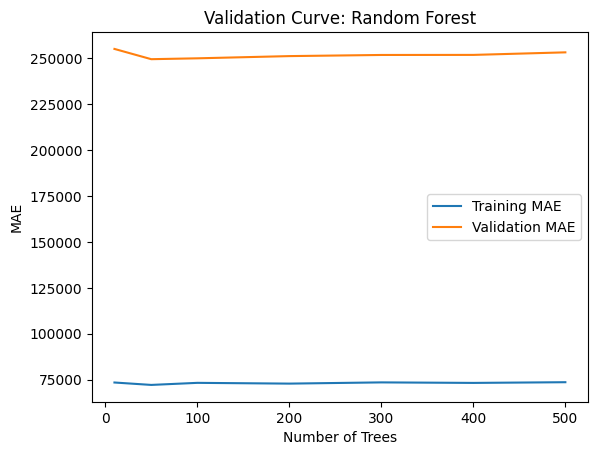

In [140]:
plt.plot(n_estimators, train_maes, label='Training MAE')
plt.plot(n_estimators, valid_maes, label='Validation MAE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
plt.legend()
plt.title('Validation Curve: Random Forest')
plt.show()

In [143]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train_processed, train_y)
preds_test_rf = rf_model.predict(X_test_processed)
score = mean_absolute_error(test_y, preds_test_rf)
print("MAE: {}".format(score))

MAE: 237270.7562189055


In [144]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
k = 10  
kf = KFold(n_splits=k, random_state=42, shuffle=True)
fold_scores = []
model = RandomForestRegressor(n_estimators=100, random_state=0)

for train_index, val_index in kf.split(X_train_processed):
    fold_train_X, fold_val_X = X_train_processed[train_index], X_train_processed[val_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[val_index]
    model.fit(X=fold_train_X, y=fold_train_y)
    fold_preds = model.predict(fold_val_X)
    fold_score = mean_absolute_error(fold_val_y, fold_preds)
    fold_scores.append(fold_score)
average_score = np.mean(fold_scores)
print("Durchschnittlicher MAE über 10 Folds:", average_score)
test_preds = model.predict(X_test_processed)
test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)

Durchschnittlicher MAE über 10 Folds: 219593.1497388414
MAE auf Testdaten: 232625.70572139302
